Le dataset data_rating_corporate contient des observations événementielles de notations de crédit attribuées à des entreprises par des agences de rating. Après mise en forme en panel temporel, ces données permettent de reconstruire les migrations de rating par secteur, qui constituent l’information clé utilisée pour extraire les facteurs de risque systémiques sectoriels dans le cadre du modèle CreditMetrics.

In [1]:
! pip install pandas openpyxl



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

In [3]:

# Charger le fichier Excel
df = pd.read_excel("data\credit_ratings\data_rating_corporate.xlsx")

# Afficher les premières lignes
df.head()


,rating_agency_name,rating,rating_action_date,legal_entity_identifier,obligor_name,year_month,year,pays,nace
0,Egan-Jones Ratings Company,B,2022-07-22,NaN,"06 ENVIRONMENTAL, LLC",2022-07-01,2023,NaN,RU
1,Egan-Jones Ratings Company,B,2023-07-21,NaN,"06 ENVIRONMENTAL, LLC",2023-07-01,2024,NaN,RU
2,Egan-Jones Ratings Company,B,2023-09-18,NaN,"06 ENVIRONMENTAL, LLC",2023-09-01,2024,NaN,RU
3,Fitch Ratings,B,2021-08-18,549300ETSKJL315VDV79,"11065220 Canada, Inc.",2021-08-01,2022,NaN,RU
4,Fitch Ratings,C,2022-06-27,549300ETSKJL315VDV79,"11065220 Canada, Inc.",2022-06-01,2022,NaN,RU


In [4]:
df.info()
df.describe()
df.dtypes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109161 entries, 0 to 109160
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   rating_agency_name       109161 non-null  object
 1   rating                   109161 non-null  object
 2   rating_action_date       109161 non-null  object
 3   legal_entity_identifier  64310 non-null   object
 4   obligor_name             109161 non-null  object
 5   year_month               109161 non-null  object
 6   year                     109161 non-null  int64 
 7   pays                     66414 non-null   object
 8   nace                     109161 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.5+ MB


rating_agency_name         object
rating                     object
rating_action_date         object
legal_entity_identifier    object
obligor_name               object
year_month                 object
year                        int64
pays                       object
nace                       object
dtype: object

In [5]:



import pandas as pd
import numpy as np

def clean_data_rating_corporate(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) Dates
    df["rating_action_date"] = pd.to_datetime(df["rating_action_date"], errors="coerce")

    # year_month : souvent "YYYY-MM-01" en string -> datetime Month Start
    df["year_month"] = pd.to_datetime(df["year_month"], errors="coerce")

    # Si year_month est manquant mais rating_action_date est dispo, on le reconstruit
    missing_ym = df["year_month"].isna() & df["rating_action_date"].notna()
    df.loc[missing_ym, "year_month"] = df.loc[missing_ym, "rating_action_date"].dt.to_period("M").dt.to_timestamp()

    # 2) Strings : trim
    for c in ["rating_agency_name", "rating", "legal_entity_identifier", "obligor_name", "pays", "nace"]:
        df[c] = df[c].astype("string").str.strip()

    # 3) ID entreprise : LEI si dispo sinon nom
    lei_ok = df["legal_entity_identifier"].notna() & (df["legal_entity_identifier"] != "")
    name_ok = df["obligor_name"].notna() & (df["obligor_name"] != "")
    df["obligor_id"] = np.where(lei_ok, df["legal_entity_identifier"], np.where(name_ok, df["obligor_name"], pd.NA))

    # 4) Nettoyage secteur (NACE)
    # (Tu peux adapter selon ton codage : lettres, divisions, etc.)
    df["nace"] = df["nace"].str.upper()

    # 5) Nettoyage rating
    df["rating"] = df["rating"].str.upper()

    # 6) Filtrer les lignes inutilisables
    df = df[df["obligor_id"].notna()].copy()
    df = df[df["year_month"].notna()].copy()
    df = df[df["nace"].notna() & (df["nace"] != "")].copy()
    df = df[df["rating"].notna() & (df["rating"] != "")].copy()

    return df


def quick_diagnostics(df: pd.DataFrame):
    print("---- DIAGNOSTICS ----")
    print("Nb lignes:", len(df))
    print("Nb entreprises (obligor_id):", df["obligor_id"].nunique())
    print("Nb agences:", df["rating_agency_name"].nunique())
    print("Nb secteurs (nace):", df["nace"].nunique())
    print("Période year_month:", df["year_month"].min(), "->", df["year_month"].max())

    print("\nTop agences:")
    print(df["rating_agency_name"].value_counts().head(10))

    print("\nTop ratings:")
    print(df["rating"].value_counts().head(15))

    print("\nTop secteurs (nace):")
    print(df["nace"].value_counts().head(15))






In [6]:
df_clean = clean_data_rating_corporate(df)
quick_diagnostics(df_clean)

---- DIAGNOSTICS ----
Nb lignes: 109161
Nb entreprises (obligor_id): 13944
Nb agences: 5
Nb secteurs (nace): 18
Période year_month: 2010-07-01 00:00:00 -> 2024-04-01 00:00:00

Top agences:
rating_agency_name
Egan-Jones Ratings Company            55414
Standard & Poor's Ratings Services    38151
Moody's Investors Service              6306
Japan Credit Rating Agency,Ltd.        5856
Fitch Ratings                          3434
Name: count, dtype: Int64

Top ratings:
rating
BBB    29025
B      24599
A      22268
BB     20638
C       6638
AAA     5482
D        511
Name: count, dtype: Int64

Top secteurs (nace):
nace
KZ    13782
C5    13418
C3    11983
RU    10508
JZ    10142
BZ     8418
LZ     7427
HZ     6164
GZ     5047
C1     5032
OQ     4664
CH     2398
C4     2337
C2     2322
IZ     1901
Name: count, dtype: Int64


In [7]:
agency_dist = (
    df_clean["rating_agency_name"]
    .value_counts()
    .rename_axis("Agence")
    .reset_index(name="Nombre d'observations")
)

agency_dist["Part (%)"] = 100 * agency_dist["Nombre d'observations"] / agency_dist["Nombre d'observations"].sum()
agency_dist


,Agence,Nombre d'observations,Part (%)
0,Egan-Jones Ratings Company,55414,50.763551
1,Standard & Poor's Ratings Services,38151,34.949295
2,Moody's Investors Service,6306,5.776788
3,"Japan Credit Rating Agency,Ltd.",5856,5.364553
4,Fitch Ratings,3434,3.145812


On garde que les notations edgar jones pour l'instant


In [8]:
def filter_and_map_ratings(df):
    df = df.copy()

    # 1) Garder Egan-Jones
    df = df[df["rating_agency_name"] == "Egan-Jones Ratings Company"].copy()
    return df

In [9]:
df_ej= filter_and_map_ratings(df_clean)
df_ej["rating"].value_counts()

rating
BBB    16308
A      13160
BB     12106
B       7724
C       3212
AAA     2860
D         44
Name: count, dtype: Int64

In [10]:
import pandas as pd
import numpy as np

# -----------------------------
# 0) Mapping rating -> grille coarse (AAA..D)
# -----------------------------
RATING_MAP = {
    # Investment grade
    "AAA": "AAA",
    "AA": "AA",
    "A": "A",
    "BBB": "BBB",

    # Speculative grade
    "BB": "BB",
    "B": "B",

    # Distressed (coarse)
    "CCC": "C",
    "CC": "C",
    "C": "C",
    "C2": "C",
    "C3": "C",
    "C4": "C",

    # Default
    "D": "D",
    "SD": "D",

    # Non exploitable / à exclure
    "WR": None,
    "NR": None,
    "IZ": None,
}

RATING_ORDER = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"]


def build_panel_transitions_counts(
    df_ej: pd.DataFrame,
    sector_col="nace",
    month_col="year_month",
    action_date_col="rating_action_date",
    rating_col="rating",
    forward_fill_limit=None  # ex: 24 si tu veux max 2 ans de carry-forward
):
    df = df_ej.copy()

    # 1) Cast dates (au cas où)
    df[action_date_col] = pd.to_datetime(df[action_date_col], errors="coerce")
    df[month_col] = pd.to_datetime(df[month_col], errors="coerce")

    # 2) Identifiant entreprise (on suppose que tu as déjà obligor_id)
    if "obligor_id" not in df.columns:
        # fallback : LEI sinon nom
        lei_ok = df["legal_entity_identifier"].notna() & (df["legal_entity_identifier"].astype(str).str.strip() != "")
        name_ok = df["obligor_name"].notna() & (df["obligor_name"].astype(str).str.strip() != "")
        df["obligor_id"] = np.where(lei_ok, df["legal_entity_identifier"], np.where(name_ok, df["obligor_name"], pd.NA))

    # 3) Nettoyage strings + rating mapping
    df[sector_col] = df[sector_col].astype("string").str.strip().str.upper()
    df["rating_mapped"] = df[rating_col].astype("string").str.strip().str.upper().map(RATING_MAP)

    # 4) Filtrage lignes exploitables
    df = df[df["obligor_id"].notna()].copy()
    df = df[df[month_col].notna()].copy()
    df = df[df[sector_col].notna() & (df[sector_col] != "")].copy()
    df = df[df["rating_mapped"].isin(RATING_ORDER)].copy()

    # 5) Si plusieurs événements même mois : on garde le dernier (par action_date)
    sort_cols = ["obligor_id", sector_col, month_col]
    if action_date_col in df.columns:
        sort_cols += [action_date_col]
    df = df.sort_values(sort_cols)

    monthly_last = (
        df.groupby(["obligor_id", sector_col, month_col], as_index=False)
          .last()
          [["obligor_id", sector_col, month_col, "rating_mapped"]]
          .rename(columns={"rating_mapped": "rating"})
    )

    # 6) Grille mensuelle complète + forward fill
    global_min = monthly_last[month_col].min()
    global_max = monthly_last[month_col].max()
    all_months = pd.date_range(global_min, global_max, freq="MS")

    obligors = monthly_last[["obligor_id", sector_col]].drop_duplicates()

    grid = obligors.assign(key=1).merge(
        pd.DataFrame({month_col: all_months, "key": 1}),
        on="key",
        how="outer"
    ).drop(columns=["key"])

    panel = grid.merge(
        monthly_last,
        on=["obligor_id", sector_col, month_col],
        how="left"
    ).sort_values(["obligor_id", sector_col, month_col])

    panel["rating"] = (
        panel.groupby(["obligor_id", sector_col])["rating"]
             .ffill(limit=forward_fill_limit)
    )
    panel = panel[panel["rating"].notna()].copy()

    # 7) Transitions t-1 -> t
    panel["rating_prev"] = panel.groupby(["obligor_id", sector_col])["rating"].shift(1)

    transitions = panel[panel["rating_prev"].notna()].copy()
    transitions["changed"] = (transitions["rating_prev"] != transitions["rating"]).astype(int)

    transitions = transitions.rename(columns={sector_col: "sector", month_col: "month"})[
        ["obligor_id", "sector", "month", "rating_prev", "rating", "changed"]
    ]

    # 8) Comptages N_{s,t}(r->k)
    counts = (
        transitions
        .groupby(["sector", "month", "rating_prev", "rating"], as_index=False)
        .size()
        .rename(columns={"size": "n"})
        .sort_values(["sector", "month", "rating_prev", "rating"])
    )

    panel = panel.rename(columns={sector_col: "sector", month_col: "month"})[
        ["obligor_id", "sector", "month", "rating"]
    ].sort_values(["sector", "obligor_id", "month"])

    return panel, transitions, counts


# -----------------------------
# RUN
# -----------------------------
panel, transitions, counts = build_panel_transitions_counts(df_ej)

print("Panel:", panel.shape, " | entreprises:", panel["obligor_id"].nunique())
print("Transitions:", transitions.shape)
print("Counts:", counts.shape)

print("\nExemple counts:")
print(counts.head(10))


Panel: (305714, 4)  | entreprises: 4552
Transitions: (301162, 6)
Counts: (17993, 5)

Exemple counts:
  sector      month rating_prev rating  n
0     AZ 2011-06-01           A      A  1
1     AZ 2011-07-01           A      A  1
2     AZ 2011-08-01           A      A  1
3     AZ 2011-09-01           A      A  1
4     AZ 2011-10-01           A      A  1
5     AZ 2011-11-01           A      A  2
6     AZ 2011-12-01           A      A  2
7     AZ 2012-01-01           A      A  2
8     AZ 2012-02-01           A      A  3
9     AZ 2012-03-01           A      A  3


In [11]:
# % de transitions où ça bouge vraiment (sinon trop de bruit / trop de ffill)
chg_rate = transitions["changed"].mean()
print("Taux de changement mensuel:", round(100*chg_rate, 2), "%")

# couverture par secteur
print("\nNb obs par secteur (counts):")
print(counts["sector"].value_counts().head(10))

# un mois exemple: matrice r->k pour un secteur
s0 = counts["sector"].iloc[0]
t0 = counts["month"].min()
mat = counts[(counts["sector"]==s0) & (counts["month"]==t0)].pivot_table(
    index="rating_prev", columns="rating", values="n", aggfunc="sum", fill_value=0
)
print(f"\nMatrice de comptage pour secteur={s0}, mois={t0.date()}:")
print(mat)


Taux de changement mensuel: 1.12 %

Nb obs par secteur (counts):
sector
C5    1302
C3    1302
KZ    1267
BZ    1231
JZ    1203
RU    1181
HZ    1175
OQ    1161
GZ    1084
C1     947
Name: count, dtype: Int64

Matrice de comptage pour secteur=AZ, mois=2011-02-01:
Empty DataFrame
Columns: []
Index: []


In [12]:
# nombre de mois couverts par secteur
months_per_sector = counts.groupby("sector")["month"].nunique().sort_values(ascending=False)
print(months_per_sector)

# nombre total de transitions observées par secteur
trans_per_sector = transitions.groupby("sector").size().sort_values(ascending=False)
print(trans_per_sector)


sector
C5    158
C1    158
OQ    158
KZ    158
LZ    158
JZ    157
C2    157
BZ    156
RU    156
C4    155
GZ    155
IZ    155
AZ    154
C3    154
CH    154
HZ    153
MN    152
FZ    147
Name: month, dtype: int64
sector
KZ    46462
C5    35926
C3    32693
JZ    31843
RU    30031
OQ    19721
LZ    17504
BZ    15656
C1    14066
GZ    13657
HZ    12706
MN     7376
IZ     5606
C4     5529
CH     4572
C2     3284
FZ     2467
AZ     2063
dtype: int64


In [13]:
import pandas as pd
import numpy as np

RATING_ORDER = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"]

def make_counts_creditmetrics(transitions: pd.DataFrame) -> pd.DataFrame:
    """
    transitions: colonnes attendues
      ['obligor_id','sector','month','rating_prev','rating','changed']
    Retourne counts_creditmetrics avec toutes les cellules, y compris r->r.
    """
    # total exposés par (sector, month, rating_prev)
    n_initial = (
        transitions
        .groupby(["sector", "month", "rating_prev"], as_index=False)
        .agg(n_total=("obligor_id", "nunique"))
    )

    # migrations observées (y compris r->r si ça existe déjà)
    n_migrations = (
        transitions
        .groupby(["sector", "month", "rating_prev", "rating"], as_index=False)
        .size()
        .rename(columns={"size": "n"})
    )

    # sorties hors stay
    outgoing = (
        n_migrations[n_migrations["rating"] != n_migrations["rating_prev"]]
        .groupby(["sector", "month", "rating_prev"], as_index=False)
        .agg(n_out=("n", "sum"))
    )

    tmp = n_initial.merge(outgoing, on=["sector", "month", "rating_prev"], how="left")
    tmp["n_out"] = tmp["n_out"].fillna(0).astype(int)
    tmp["n_stay"] = tmp["n_total"] - tmp["n_out"]

    stays = tmp[["sector", "month", "rating_prev", "n_stay"]].copy()
    stays["rating"] = stays["rating_prev"]
    stays = stays.rename(columns={"n_stay": "n"})

    counts_creditmetrics = pd.concat([n_migrations, stays], ignore_index=True)

    # nettoyage / tri
    counts_creditmetrics = counts_creditmetrics[
        counts_creditmetrics["rating_prev"].isin(RATING_ORDER) &
        counts_creditmetrics["rating"].isin(RATING_ORDER)
    ].copy()

    counts_creditmetrics = counts_creditmetrics.groupby(
        ["sector", "month", "rating_prev", "rating"], as_index=False
    )["n"].sum()

    counts_creditmetrics = counts_creditmetrics.sort_values(
        ["sector", "month", "rating_prev", "rating"]
    )

    # check : somme_k N(r->k) = n_total
    check = (
        counts_creditmetrics.groupby(["sector", "month", "rating_prev"])["n"].sum()
    )
    if (check <= 0).any():
        raise ValueError("Check failed: certains (sector,month,rating_prev) ont une somme <= 0.")

    return counts_creditmetrics


counts_creditmetrics = make_counts_creditmetrics(transitions)

print("counts_creditmetrics shape:", counts_creditmetrics.shape)
print(counts_creditmetrics.head(10))


counts_creditmetrics shape: (18019, 5)
  sector      month rating_prev rating  n
0     AZ 2011-06-01           A      A  2
1     AZ 2011-07-01           A      A  2
2     AZ 2011-08-01           A      A  2
3     AZ 2011-09-01           A      A  2
4     AZ 2011-10-01           A      A  2
5     AZ 2011-11-01           A      A  4
6     AZ 2011-12-01           A      A  4
7     AZ 2012-01-01           A      A  4
8     AZ 2012-02-01           A      A  6
9     AZ 2012-03-01           A      A  6


In [14]:
from scipy.stats import norm

def build_ttc_and_barriers(counts_creditmetrics: pd.DataFrame):
    """
    TTC globale: P_TTC(r->k) basée sur l'agrégation de tous secteurs & mois.
    Barrières: b_{r,k} = Phi^{-1}(cumprob_{r}(k))
    """
    agg = (
        counts_creditmetrics
        .groupby(["rating_prev", "rating"], as_index=False)["n"].sum()
    )

    # probabilités TTC
    agg["row_sum"] = agg.groupby("rating_prev")["n"].transform("sum")
    agg["p_ttc"] = agg["n"] / agg["row_sum"]

    # matrice TTC
    P = agg.pivot_table(index="rating_prev", columns="rating", values="p_ttc", fill_value=0.0)

    # assurer l'ordre
    P = P.reindex(index=RATING_ORDER, columns=RATING_ORDER, fill_value=0.0)

    # cumul sur colonnes "de meilleur -> pire" (on suppose que l’ordre dans RATING_ORDER va AAA ... D)
    # Ici, on veut des seuils pour états ordonnés : cumprob(k) = sum_{j <= k} P(r->j)
    # Comme AAA est "meilleur", et D "pire", "j <= k" dépend du sens.
    # On va définir l'ordre du meilleur vers le pire dans RATING_ORDER, et prendre le cumul de gauche->droite.
    cumP = P.cumsum(axis=1)

    # barrières b_{r,k} = Phi^{-1}(cumP[r,k])
    # bornage numérique pour éviter inf
    eps = 1e-10
    barriers = cumP.clip(lower=eps, upper=1 - eps).apply(norm.ppf)

    return P, barriers

P_ttc, barriers = build_ttc_and_barriers(counts_creditmetrics)

print("P_ttc (extrait):")
print(P_ttc.iloc[:4, :4])

print("\nBarrières (extrait):")
print(barriers.iloc[:4, :4])


P_ttc (extrait):
rating            AAA   AA         A       BBB
rating_prev                                   
AAA          0.994047  0.0  0.005859  0.000094
AA           0.000000  0.0  0.000000  0.000000
A            0.001332  0.0  0.993939  0.004628
BBB          0.000007  0.0  0.002754  0.993785

Barrières (extrait):
rating            AAA        AA         A       BBB
rating_prev                                        
AAA          2.514938  2.514938  3.735308  6.361341
AA          -6.361341 -6.361341 -6.361341 -6.361341
A           -3.003981 -3.003981  2.595086  3.718569
BBB         -4.350229 -4.350229 -2.774927  2.701220


In [15]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# -----------------------------
# Paramètres
# -----------------------------
RATING_ORDER = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"]
rho = 0.20
a = np.sqrt(rho)
b = np.sqrt(1 - rho)

# -----------------------------
# 1) Construire les seuils (barrières) utilisables
#    barriers[r, k] = Phi^{-1}(P(R <= k | r)) (cumul)
#    Pour K catégories: on a K-1 seuils finits (avant la dernière catégorie)
# -----------------------------
def build_thresholds_from_barriers(barriers: pd.DataFrame):
    """
    Retourne un dict thresholds[r] = array de taille K+1 :
      [-inf, t1, t2, ..., t_{K-1}, +inf]
    où t_j est la frontière entre catégories j et j+1.
    """
    cols = RATING_ORDER
    # on prend les seuils cumulés jusqu'à l'avant-dernière catégorie
    finite_cols = cols[:-1]  # jusqu'à "C"
    thresholds = {}

    for r in cols:
        t = [-np.inf]
        # t1 = seuil après AAA, t2 = après AA, ..., t_{K-1} = après C
        for k in finite_cols:
            t.append(float(barriers.loc[r, k]))
        t.append(np.inf)
        thresholds[r] = np.array(t, dtype=float)

    return thresholds

thresholds = build_thresholds_from_barriers(barriers)

# Pour chaque rating_prev r et chaque rating k, on prépare (lower, upper)
rating_to_idx = {r:i for i, r in enumerate(RATING_ORDER)}

lower_upper = {}
for r in RATING_ORDER:
    t = thresholds[r]  # taille K+1
    # catégorie k correspond à intervalle (t[k], t[k+1])
    for k in RATING_ORDER:
        kk = rating_to_idx[k]
        lower_upper[(r, k)] = (t[kk], t[kk+1])

# -----------------------------
# 2) Probabilité conditionnelle p(r->k | z)
# -----------------------------
def p_rk_given_z(r_prev, r_next, z):
    lo, up = lower_upper[(r_prev, r_next)]
    # X | z ~ N(a*z, b^2), donc P(lo < X <= up)
    u = (up - a*z) / b
    l = (lo - a*z) / b
    return norm.cdf(u) - norm.cdf(l)

# -----------------------------
# 3) NLL pour un (sector, month)
# -----------------------------
def nll_group(z, sub_df):
    # sub_df contient des lignes rating_prev, rating, n
    # Stabilisation numérique
    eps = 1e-12
    ll = 0.0
    for r_prev, r_next, n in zip(sub_df["rating_prev"], sub_df["rating"], sub_df["n"]):
        p = p_rk_given_z(r_prev, r_next, z)
        if p < eps:
            p = eps
        ll += n * np.log(p)
    return -ll

# -----------------------------
# 4) Estimation MLE de Z_{s,t} pour tous secteurs/mois
# -----------------------------
def estimate_Z_all(counts_creditmetrics: pd.DataFrame, z_bounds=(-6, 6)):
    results = []
    grouped = counts_creditmetrics.groupby(["sector", "month"], sort=True)

    for (s, m), sub in grouped:
        # on ne garde que les ratings de la grille
        sub = sub[sub["rating_prev"].isin(RATING_ORDER) & sub["rating"].isin(RATING_ORDER)].copy()
        if len(sub) == 0:
            continue

        opt = minimize_scalar(
            nll_group,
            bounds=z_bounds,
            method="bounded",
            args=(sub,)
        )

        results.append({
            "sector": s,
            "month": m,
            "z_hat": float(opt.x),
            "nll": float(opt.fun),
            "success": bool(opt.success),
            "n_obs_cells": int(len(sub)),
            "n_total": int(sub["n"].sum())
        })

    Z = pd.DataFrame(results).sort_values(["sector", "month"])
    return Z

Z_hat = estimate_Z_all(counts_creditmetrics)

print("Z_hat:", Z_hat.shape)
print("Taux succès optimisation:", round(100*Z_hat["success"].mean(), 2), "%")
print(Z_hat.head())


Z_hat: (2795, 7)
Taux succès optimisation: 100.0 %
  sector      month     z_hat     nll  success  n_obs_cells  n_total
0     AZ 2011-06-01 -0.457159  0.0035     True            1        2
1     AZ 2011-07-01 -0.457159  0.0035     True            1        2
2     AZ 2011-08-01 -0.457159  0.0035     True            1        2
3     AZ 2011-09-01 -0.457159  0.0035     True            1        2
4     AZ 2011-10-01 -0.457159  0.0035     True            1        2


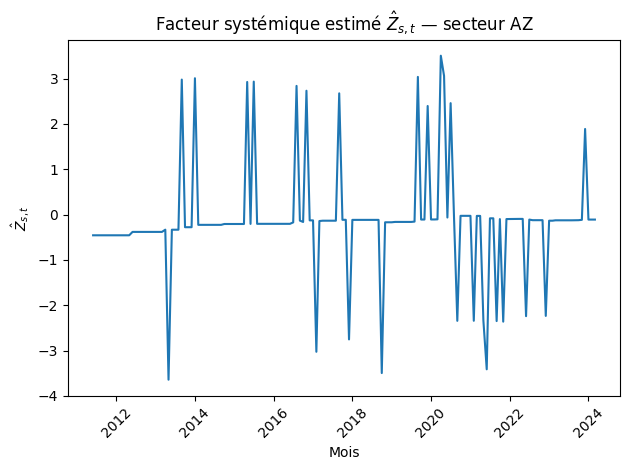

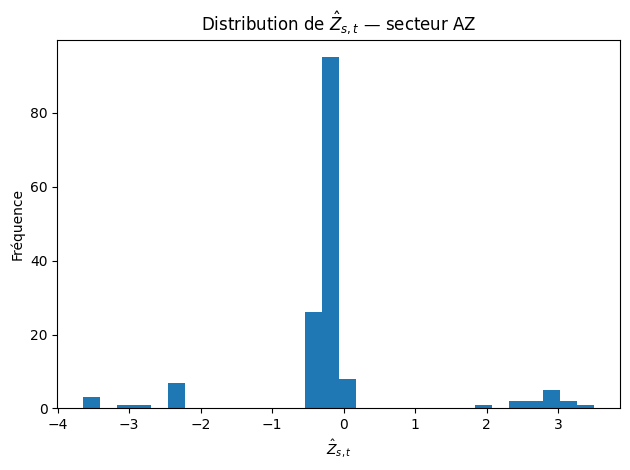

In [16]:
sector_show = "AZ"  # change si besoin

Zs = Z_hat[Z_hat["sector"] == sector_show].copy()
Zs = Zs[Zs["success"]].copy()

# Série temporelle
plt.figure()
plt.plot(Zs["month"], Zs["z_hat"])
plt.title(f"Facteur systémique estimé $\\hat{{Z}}_{{s,t}}$ — secteur {sector_show}")
plt.xlabel("Mois")
plt.ylabel("$\\hat{Z}_{s,t}$")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution
plt.figure()
plt.hist(Zs["z_hat"], bins=30)
plt.title(f"Distribution de $\\hat{{Z}}_{{s,t}}$ — secteur {sector_show}")
plt.xlabel("$\\hat{Z}_{s,t}$")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()


In [17]:
rating_initial_show = "BBB"

# Seuils (frontières) entre catégories (AAA|AA|...|C|D)
# On affiche les seuils cumulés : après AAA, après AA, ..., après C
bar_table = barriers.loc[rating_initial_show, RATING_ORDER[:-1]].to_frame(name="barrier_phi_inv_cumprob")
print(bar_table)


        barrier_phi_inv_cumprob
rating                         
AAA                   -4.350229
AA                    -4.350229
A                     -2.774927
BBB                    2.701220
BB                     3.770081
B                      4.035880
C                      4.350229


In [18]:
# 1) Z doit avoir une variance raisonnable (pas tout collé à -6 ou +6)
print("Quantiles z_hat:", Z_hat["z_hat"].quantile([0.01, 0.5, 0.99]))

# 2) secteurs avec trop peu de masse
light = Z_hat.groupby("sector")["n_total"].median().sort_values().head(5)
print("Secteurs 'légers' (médiane n_total):\n", light)


Quantiles z_hat: 0.01   -2.771314
0.50   -0.107904
0.99    2.943569
Name: z_hat, dtype: float64
Secteurs 'légers' (médiane n_total):
 sector
FZ    24.0
AZ    24.5
C2    46.0
CH    49.0
IZ    54.0
Name: n_total, dtype: float64


Normalisation du facteur systémique

In [19]:
Z_std = Z_hat.copy()

Z_std["z_std"] = (
    Z_std.groupby("sector")["z_hat"]
         .transform(lambda x: (x - x.mean()) / x.std())
)

# check
print(Z_std.groupby("sector")["z_std"].agg(["mean", "std"]).head())


                mean  std
sector                   
AZ     -2.212336e-17  1.0
BZ     -5.515531e-17  1.0
C1      6.324055e-18  1.0
C2      3.411991e-17  1.0
C3      6.848778e-18  1.0


In [20]:
import os
import json
import pandas as pd

EXPORT_DIR = "exports_step1_creditmetrics_csv"
os.makedirs(EXPORT_DIR, exist_ok=True)

def save_csv(df: pd.DataFrame, name: str):
    path = os.path.join(EXPORT_DIR, f"{name}.csv")
    df.to_csv(path, index=False)
    print(f"✓ Saved {name}: {df.shape} -> {path}")


# =====================================================
# Objets attendus en mémoire :
# panel
# transitions
# counts_creditmetrics
# P_ttc
# barriers
# Z_hat
# =====================================================

# 1) Panel mensuel
save_csv(panel, "panel_monthly_ratings")

# 2) Transitions
save_csv(transitions, "transitions_monthly")

# 3) Comptages CreditMetrics (avec stays)
save_csv(counts_creditmetrics, "counts_creditmetrics_full")

# 4) Facteur systémique estimé
save_csv(Z_hat, "Z_hat_sector_month")

# 5) Facteur systémique standardisé
Z_std = Z_hat.copy()
Z_std["z_std"] = (
    Z_std.groupby("sector")["z_hat"]
         .transform(lambda x: (x - x.mean()) / x.std())
)
save_csv(Z_std, "Z_hat_standardized_sector_month")

# 6) TTC (format long)
P_ttc_long = (
    P_ttc.reset_index()
         .melt(id_vars="rating_prev",
               var_name="rating",
               value_name="p_ttc")
)
save_csv(P_ttc_long, "P_ttc_global_long")

# 7) Barrières (format long)
barriers_long = (
    barriers.reset_index()
            .melt(id_vars="rating_prev",
                  var_name="rating",
                  value_name="barrier_phi_inv_cumprob")
)
save_csv(barriers_long, "barriers_global_long")


# 8) Métadonnées (choix méthodologiques)
meta = {
    "rho": 0.20,
    "rating_order": ["AAA", "AA", "A", "BBB", "BB", "B", "C", "D"],
    "agency_used": "Egan-Jones Ratings Company",
    "frequency": "monthly",
    "notes": "counts_creditmetrics_full inclut les stays (r->r). Barrières dérivées de la TTC globale."
}

with open(os.path.join(EXPORT_DIR, "metadata_step1.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("\n✓ Tous les fichiers CSV + metadata exportés")


✓ Saved panel_monthly_ratings: (305714, 4) -> exports_step1_creditmetrics_csv\panel_monthly_ratings.csv
✓ Saved transitions_monthly: (301162, 6) -> exports_step1_creditmetrics_csv\transitions_monthly.csv
✓ Saved counts_creditmetrics_full: (18019, 5) -> exports_step1_creditmetrics_csv\counts_creditmetrics_full.csv
✓ Saved Z_hat_sector_month: (2795, 7) -> exports_step1_creditmetrics_csv\Z_hat_sector_month.csv
✓ Saved Z_hat_standardized_sector_month: (2795, 8) -> exports_step1_creditmetrics_csv\Z_hat_standardized_sector_month.csv
✓ Saved P_ttc_global_long: (64, 3) -> exports_step1_creditmetrics_csv\P_ttc_global_long.csv
✓ Saved barriers_global_long: (64, 3) -> exports_step1_creditmetrics_csv\barriers_global_long.csv

✓ Tous les fichiers CSV + metadata exportés


In [23]:
Z_hat

,sector,month,z_hat,nll,success,n_obs_cells,n_total
0,AZ,2011-06-01,-0.457159,0.003500,True,1,2
1,AZ,2011-07-01,-0.457159,0.003500,True,1,2
2,AZ,2011-08-01,-0.457159,0.003500,True,1,2
3,AZ,2011-09-01,-0.457159,0.003500,True,1,2
4,AZ,2011-10-01,-0.457159,0.003500,True,1,2
...,...,...,...,...,...,...,...
2790,RU,2023-11-01,0.289406,8.533978,True,8,1115
2791,RU,2023-12-01,0.529571,15.363542,True,9,1148
2792,RU,2024-01-01,0.513405,14.919499,True,8,1172
2793,RU,2024-02-01,0.943029,33.273048,True,10,1184


## REGROUPEMENT CORRELATION DES FACTEURS SYSTEMIQUE

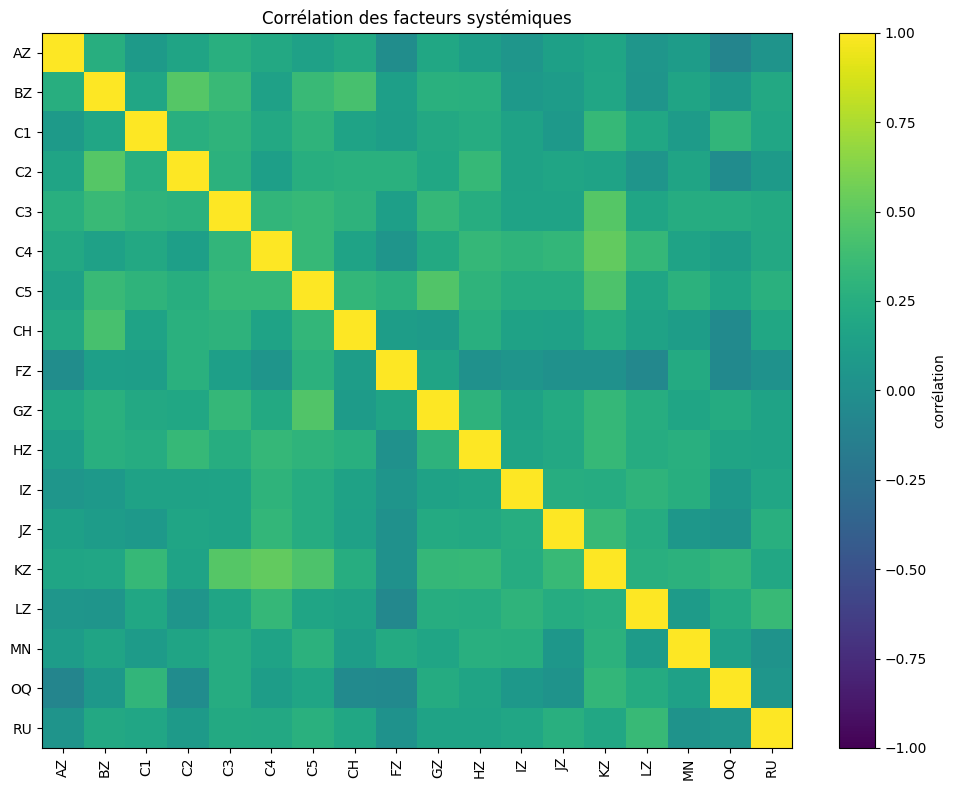

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def corr_matrix_Z(df_Z, date_col="date", sector_col="sector", z_col="Z",
                  method="pearson", min_periods=24):
    """
    Retourne:
      - Z_wide : matrice (dates x secteurs) des facteurs
      - corr   : matrice de corrélation (secteurs x secteurs)
    min_periods: nb min de dates communes pour calculer une corrélation.
    """
    # Pivot: dates x secteurs
    Z_wide = (df_Z
              .pivot_table(index=date_col, columns=sector_col, values=z_col, aggfunc="mean")
              .sort_index())

    # Corrélation avec gestion des NA
    corr = Z_wide.corr(method=method, min_periods=min_periods)

    return Z_wide, corr


def plot_corr_heatmap(corr, title="Corrélation des facteurs systémiques", figsize=(10, 8),
                      vmin=-1, vmax=1):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(corr.values, vmin=vmin, vmax=vmax, aspect="auto")
    ax.set_title(title)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticklabels(corr.index)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("corrélation")
    plt.tight_layout()
    plt.show()


# --- Usage ---
Z_wide, corr = corr_matrix_Z(Z_hat, date_col="month", sector_col="sector", z_col="z_hat")
plot_corr_heatmap(corr)


In [26]:
corr

sector,AZ,BZ,C1,C2,C3,C4,C5,CH,FZ,GZ,HZ,IZ,JZ,KZ,LZ,MN,OQ,RU
sector,,,,,,,,,,,,,,,,,,
AZ,1.000000,0.252614,0.090182,0.170608,0.260405,0.203611,0.144567,0.203846,-0.019796,0.190798,0.124657,0.050530,0.135045,0.177210,0.054324,0.104380,-0.092334,0.031482
BZ,0.252614,1.000000,0.186683,0.469084,0.355462,0.143754,0.355832,0.417515,0.127466,0.265771,0.258489,0.071664,0.103522,0.181028,0.043363,0.167077,0.062798,0.210323
C1,0.090182,0.186683,1.000000,0.265463,0.304642,0.205120,0.302402,0.162237,0.118270,0.210333,0.241829,0.148806,0.084592,0.340768,0.192083,0.097027,0.313619,0.184757
C2,0.170608,0.469084,0.265463,1.000000,0.282090,0.130337,0.255089,0.268428,0.271300,0.189385,0.338795,0.151648,0.172318,0.156821,0.044130,0.165427,-0.029515,0.092984
C3,0.260405,0.355462,0.304642,0.282090,1.000000,0.315856,0.336201,0.292733,0.129015,0.332043,0.243111,0.158848,0.160082,0.475538,0.173549,0.236288,0.234688,0.213593
C4,0.203611,0.143754,0.205120,0.130337,0.315856,1.000000,0.337686,0.164062,0.039102,0.215240,0.332910,0.298190,0.321350,0.520430,0.329365,0.163397,0.113949,0.208847
C5,0.144567,0.355832,0.302402,0.255089,0.336201,0.337686,1.000000,0.327174,0.283053,0.458092,0.303786,0.240810,0.241541,0.441493,0.176296,0.286460,0.177444,0.270200
CH,0.203846,0.417515,0.162237,0.268428,0.292733,0.164062,0.327174,1.000000,0.109921,0.093806,0.260676,0.150128,0.145849,0.243066,0.154102,0.116784,-0.040164,0.190384
FZ,-0.019796,0.127466,0.118270,0.271300,0.129015,0.039102,0.283053,0.109921,1.000000,0.168644,0.008517,0.044328,0.011435,0.011969,-0.066033,0.225484,-0.054606,0.017639


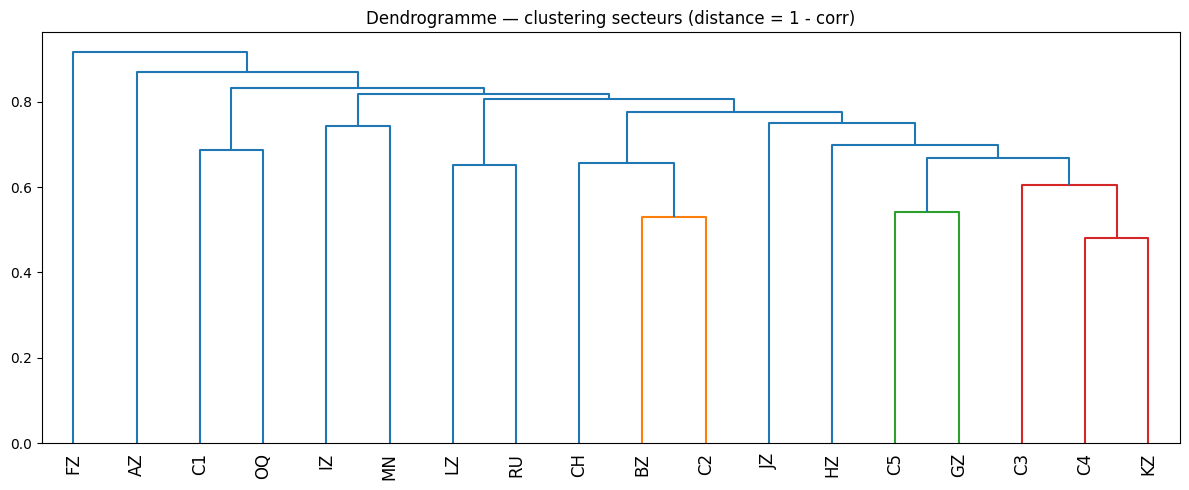

sector
C1    1
OQ    1
MN    2
IZ    2
RU    3
LZ    3
C2    4
BZ    4
CH    4
C5    5
KZ    5
GZ    5
JZ    5
HZ    5
C3    5
C4    5
AZ    6
FZ    7
Name: cluster_id, dtype: int32


In [28]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

def cluster_sectors_from_corr(corr, n_groups=8, method="average", plot=True, figsize=(12, 5)):
    """
    corr: DataFrame (secteurs x secteurs)
    n_groups: nb de groupes souhaités
    method: 'average', 'complete', 'ward' (ward nécessite une distance euclidienne)
    Retour:
      - groups: Series secteur -> id_groupe
    """
    # distance = 1 - corr ; on remplace NA par 0 de corr => distance 1
    corr_filled = corr.fillna(0.0)
    dist = 1.0 - corr_filled

    # squareform attend une matrice de distance symétrique avec diagonale 0
    np.fill_diagonal(dist.values, 0.0)
    dist_condensed = squareform(dist.values, checks=False)

    Z_link = linkage(dist_condensed, method=method)

    if plot:
        plt.figure(figsize=figsize)
        dendrogram(Z_link, labels=corr.index.tolist(), leaf_rotation=90)
        plt.title("Dendrogramme — clustering secteurs (distance = 1 - corr)")
        plt.tight_layout()
        plt.show()

    cluster_ids = fcluster(Z_link, t=n_groups, criterion="maxclust")
    groups = pd.Series(cluster_ids, index=corr.index, name="cluster_id").sort_values()

    return groups


# --- Usage ---
groups = cluster_sectors_from_corr(corr, n_groups=7, method="average", plot=True)
print(groups)


## REGROUPEMENT ECONOMIQUE

In [30]:
import pandas as pd
import numpy as np

# 1) Mapping économique (à adapter si C1..C5 sont connus chez toi)
ECON_GROUP_MAP = {
    # Primaires / énergie
    "AZ": "Primaires & énergie",
    "BZ": "Primaires & énergie",
    "DZ": "Primaires & énergie",  # si présent

    # Industrie / construction / immobilier
    "CZ": "Industrie",
    "FZ": "Construction & immobilier",
    "LZ": "Construction & immobilier",

    # Transport / info
    "HZ": "Transport & info-com",
    "JZ": "Transport & info-com",

    # Services marchands
    "GZ": "Services marchands",
    "IZ": "Services marchands",

    # Finance
    "KZ": "Finance",

    # Non-marchands / public
    "OQ": "Public & services non-marchands",
    "RU": "Public & services non-marchands",

    # Services pro (souvent très cycliques mais “services”)
    "MN": "Services pro",

    # Cas C1..C5 (à défaut)
    "C1": "Industrie",
    "C2": "Industrie",
    "C3": "Services marchands",
    "C4": "Services marchands",
    "C5": "Services pro",
    "G7": "Services marchands",  # tu avais G7 dans le dendrogramme
}

def add_econ_group(df_Z, sector_col="sector"):
    df = df_Z.copy()
    df["econ_group"] = df[sector_col].map(ECON_GROUP_MAP).fillna("Autres")
    return df

# Usage
df_Z2 = add_econ_group(Z_hat, sector_col="sector")
df_Z2["econ_group"].value_counts()


econ_group
Services marchands                 619
Industrie                          315
Public & services non-marchands    314
Primaires & énergie                310
Services pro                       310
Transport & info-com               310
Construction & immobilier          305
Finance                            158
Autres                             154
Name: count, dtype: int64

In [32]:
def aggregate_Z_by_econ_group(df_Z2, date_col="date", group_col="econ_group", z_col="Z"):
    out = (df_Z2
           .groupby([date_col, group_col], as_index=False)[z_col]
           .mean()
           .rename(columns={z_col: "Z_group"}))
    return out

# Usage
df_group = aggregate_Z_by_econ_group(df_Z2, date_col="month", group_col="econ_group", z_col="z_hat")


In [33]:
df_group

,month,econ_group,Z_group
0,2011-02-01,Construction & immobilier,-0.058740
1,2011-02-01,Finance,-4.300409
2,2011-02-01,Industrie,-0.082408
3,2011-02-01,Public & services non-marchands,-0.457159
4,2011-02-01,Services pro,-0.058740
...,...,...,...
1407,2024-03-01,Primaires & énergie,-0.090776
1408,2024-03-01,Public & services non-marchands,0.364581
1409,2024-03-01,Services marchands,0.231188
1410,2024-03-01,Services pro,0.650863


In [36]:
def corr_intra_inter(df_Z2, date_col="month", sector_col="sector", z_col="z_hat", group_col="econ_group"):
    # matrice secteurs
    Z_wide = (df_Z2.pivot_table(index=date_col, columns=sector_col, values=z_col, aggfunc="mean")
                    .sort_index())
    corr = Z_wide.corr(min_periods=24)

    # associer chaque secteur à son groupe
    sector_to_group = (df_Z2[[sector_col, group_col]]
                       .drop_duplicates()
                       .set_index(sector_col)[group_col]
                       .to_dict())

    sectors = corr.index.tolist()
    intra = []
    inter = []

    for i in range(len(sectors)):
        for j in range(i+1, len(sectors)):
            s1, s2 = sectors[i], sectors[j]
            c = corr.loc[s1, s2]
            if pd.isna(c):
                continue
            if sector_to_group.get(s1, "Autres") == sector_to_group.get(s2, "Autres"):
                intra.append(c)
            else:
                inter.append(c)

    return {
        "corr_matrix": corr,
        "intra_mean": float(np.mean(intra)) if intra else np.nan,
        "inter_mean": float(np.mean(inter)) if inter else np.nan,
        "intra_median": float(np.median(intra)) if intra else np.nan,
        "inter_median": float(np.median(inter)) if inter else np.nan,
        "n_intra_pairs": len(intra),
        "n_inter_pairs": len(inter),
    }

# Usage
diag = corr_intra_inter(df_Z2)
diag["intra_mean"], diag["inter_mean"], diag["n_intra_pairs"]


(0.20602468227428639, 0.19552443285047547, 12)

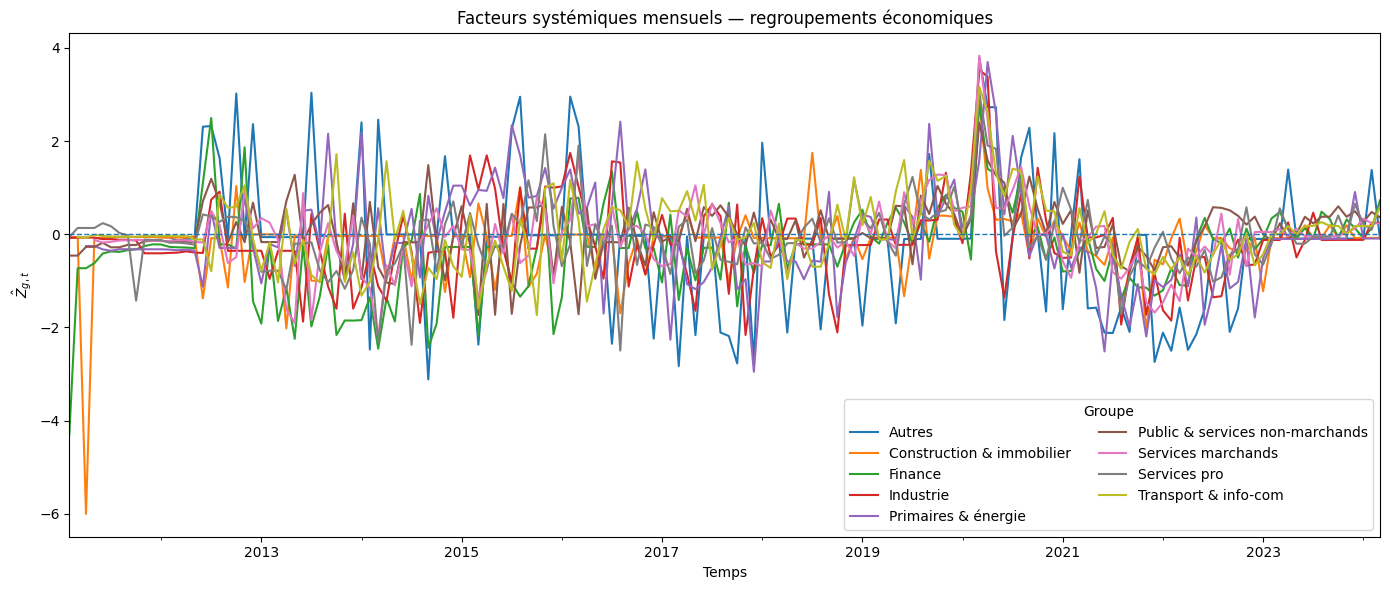

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_group_factors_from_sectors(df_Z2, date_col="month", group_col="econ_group", z_col="z_hat",
                                    title="Facteurs systémiques mensuels — regroupements économiques"):
    df = df_Z2.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # agrégation mensuelle par groupe (moyenne des secteurs dans le groupe)
    df_group = (df.groupby([date_col, group_col], as_index=False)[z_col]
                  .mean()
                  .rename(columns={z_col: "Z_group"}))

    wide = (df_group.pivot_table(index=date_col, columns=group_col, values="Z_group", aggfunc="mean")
                    .sort_index())

    ax = wide.plot(figsize=(14, 6), linewidth=1.5)
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Temps")
    ax.set_ylabel(r"$\hat{Z}_{g,t}$")
    ax.legend(title="Groupe", ncol=2, frameon=True)
    plt.tight_layout()
    plt.show()

# Exemple:
plot_group_factors_from_sectors(df_Z2)


In [45]:
import pandas as pd

def Z_groups_to_quarterly(df_group,
                          date_col="date",
                          group_col="econ_group",
                          z_col="Z_group"):
    df = df_group.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # créer la date trimestrielle
    df["date_q"] = df[date_col].dt.to_period("Q").dt.to_timestamp()

    # moyenne intra-trimestrielle
    df_q = (
        df.groupby(["date_q", group_col], as_index=False)[z_col]
          .mean()
          .sort_values([group_col, "date_q"])
    )

    return df_q


# ===== Usage =====
df_Z_group_q = Z_groups_to_quarterly(df_group, date_col="month", group_col="econ_group", z_col="Z_group")
df_Z_group_q


,date_q,econ_group,Z_group
6,2011-04-01,Autres,-0.058740
15,2011-07-01,Autres,-0.058740
24,2011-10-01,Autres,-0.058740
33,2012-01-01,Autres,-0.086835
42,2012-04-01,Autres,0.708281
...,...,...,...
437,2023-01-01,Transport & info-com,-0.139967
446,2023-04-01,Transport & info-com,0.120377
455,2023-07-01,Transport & info-com,0.206857
464,2023-10-01,Transport & info-com,0.120646


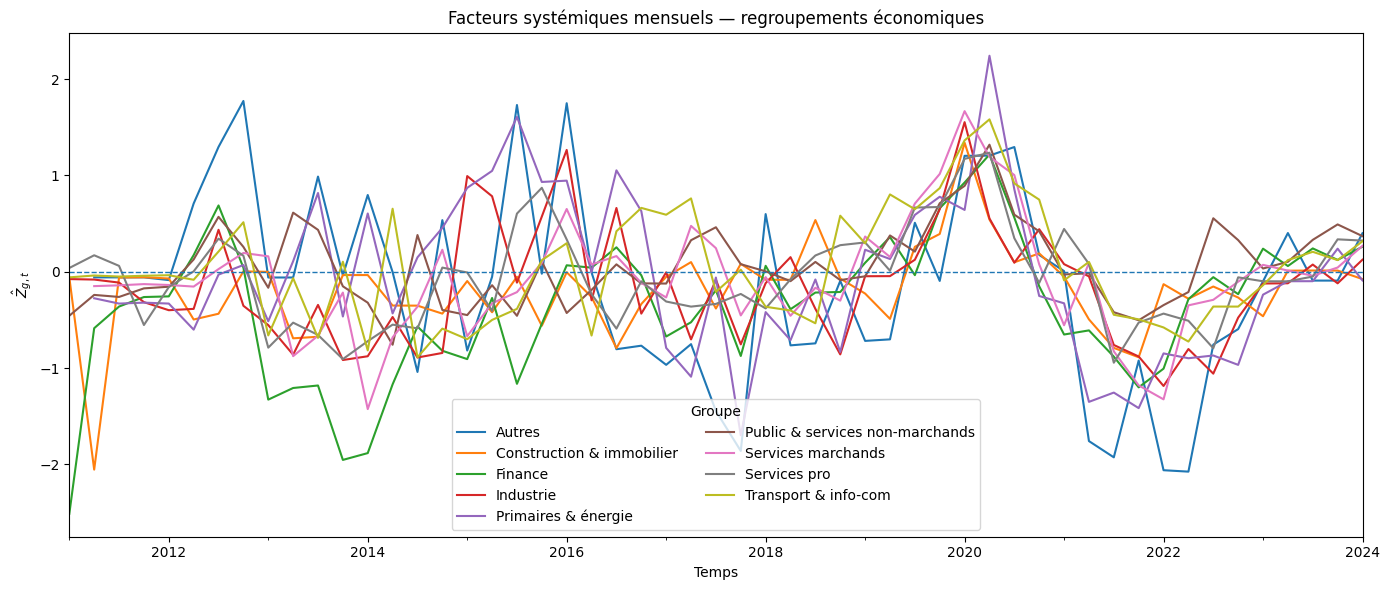

In [47]:
plot_group_factors_from_sectors(df_Z_group_q, date_col="date_q", group_col="econ_group", z_col="Z_group",
                                title="Facteurs systémiques mensuels — regroupements économiques")

In [48]:
df_Z_group_q.to_csv("exports_step1_creditmetrics_csv/Z_hat_econ_group_quarterly.csv", index=False)

# Images rapport

In [21]:
desc_table = pd.DataFrame({
    "Indicateur": [
        "Nombre d'entreprises",
        "Nombre d'observations de rating",
        "Nombre de secteurs",
        "Période couverte",
        "Agence de notation"
    ],
    "Valeur": [
        panel["obligor_id"].nunique(),
        len(panel),
        panel["sector"].nunique(),
        f"{panel['month'].min().date()} – {panel['month'].max().date()}",
        "Egan-Jones Ratings Company"
    ]
})

desc_table


,Indicateur,Valeur
0,Nombre d'entreprises,4552
1,Nombre d'observations de rating,305714
2,Nombre de secteurs,18
3,Période couverte,2011-01-01 – 2024-03-01
4,Agence de notation,Egan-Jones Ratings Company


In [32]:
agency_dist = (
    df_ej["rating_agency_name"]
    .value_counts()
    .rename_axis("Agence")
    .reset_index(name="Nombre d'observations")
)

agency_dist["Part (%)"] = 100 * agency_dist["Nombre d'observations"] / agency_dist["Nombre d'observations"].sum()
agency_dist


,Agence,Nombre d'observations,Part (%)
0,Egan-Jones Ratings Company,55414,100.0


In [22]:
transition_rate = transitions["changed"].mean()

pd.DataFrame({
    "Indicateur": ["Taux moyen de changement mensuel"],
    "Valeur": [f"{100 * transition_rate:.2f} %"]
})


,Indicateur,Valeur
0,Taux moyen de changement mensuel,1.12 %


In [23]:
P_ttc.loc[
    ["AAA", "AA", "A", "BBB"],
    ["AAA", "AA", "A", "BBB", "BB"]
]


rating,AAA,AA,A,BBB,BB
rating_prev,,,,,
AAA,0.994047,0.0,0.005859,0.000094,0.000000
AA,0.000000,0.0,0.000000,0.000000,0.000000
A,0.001332,0.0,0.993939,0.004628,0.000090
BBB,0.000007,0.0,0.002754,0.993785,0.003373


In [24]:
rating_init = "BBB"

barrier_table = (
    barriers.loc[rating_init, ["AAA","AA","A","BBB","BB","B","C"]]
    .to_frame(name="Seuil $\\Phi^{-1}(P)$")
)

barrier_table


,Seuil $\Phi^{-1}(P)$
rating,
AAA,-4.350229
AA,-4.350229
A,-2.774927
BBB,2.701220
BB,3.770081
B,4.035880
C,4.350229


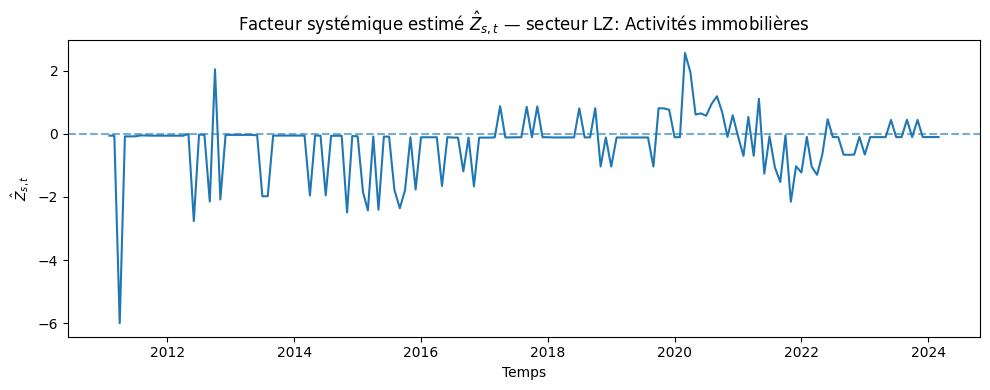

In [35]:
sector_show = "LZ"
Zs = Z_hat[Z_hat["sector"] == sector_show]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(Zs["month"], Zs["z_hat"])
plt.axhline(0, linestyle="--", alpha=0.6)
plt.title(f"Facteur systémique estimé $\\hat{{Z}}_{{s,t}}$ — secteur {sector_show}: Activités immobilières")
plt.xlabel("Temps")
plt.ylabel("$\\hat{Z}_{s,t}$")
plt.tight_layout()
plt.show()


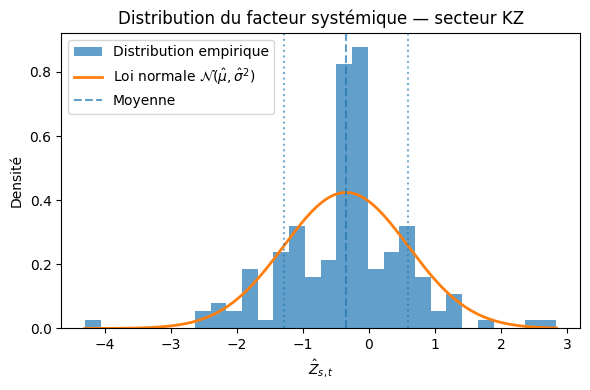

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Secteur à illustrer
sector_show = "KZ"   # adapte si besoin

# Données du facteur
Zs = Z_hat[Z_hat["sector"] == sector_show].copy()

# Paramètres empiriques
mu = Zs["z_hat"].mean()
sigma = Zs["z_hat"].std()

# Grille pour la densité normale
x = np.linspace(Zs["z_hat"].min(), Zs["z_hat"].max(), 300)

# Plot
plt.figure(figsize=(6,4))

# Histogramme normalisé
plt.hist(
    Zs["z_hat"],
    bins=30,
    density=True,
    alpha=0.7,
    label="Distribution empirique"
)

# Loi normale ajustée
plt.plot(
    x,
    norm.pdf(x, mu, sigma),
    linewidth=2,
    label=r"Loi normale $\mathcal{N}(\hat\mu,\hat\sigma^2)$"
)

plt.title(f"Distribution du facteur systémique — secteur {sector_show}")
plt.xlabel(r"$\hat{Z}_{s,t}$")
plt.ylabel("Densité")
plt.axvline(mu, linestyle="--", alpha=0.7, label="Moyenne")
plt.axvline(mu - sigma, linestyle=":", alpha=0.6)
plt.axvline(mu + sigma, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
Z_hat.groupby("sector")["z_hat"].agg(
    mean="mean",
    std="std",
    q01=lambda x: x.quantile(0.01),
    q99=lambda x: x.quantile(0.99),
    n_obs="count"
).round(3)


,mean,std,q01,q99,n_obs
sector,,,,,
AZ,-0.141,1.142,-3.454,3.050,154
BZ,0.038,1.421,-2.811,3.417,156
C1,-0.068,0.941,-2.523,2.378,158
C2,-0.249,1.294,-3.400,3.153,157
C3,-0.155,1.057,-2.395,1.866,154
C4,-0.110,1.278,-2.972,2.994,155
C5,-0.072,0.968,-2.188,2.152,158
CH,-0.137,1.373,-2.799,3.030,154
FZ,-0.031,0.924,-3.088,3.493,147
